# ĐỒ ÁN CUỐI KỲ: Lập trình song song cho CNN chuyển tiếp.

<h1>I. Mô tả đồ án</h1>

<h1>1. Tổng quan về đóng góp của các thành viên:</h1>

Thành viên         | MSSV         | Tỉ lệ đóng góp (%)    |
---                | ---          | ---                   |
Nguyễn Đức Duy     | 20127481     |30                     |
Nguyễn Hoàng Thịnh*| 20127633     |40                     |  
Lê Đức Đạt         | 20127674     |30                     |  

<h1>3. Mô tả công việc</h1>


|Numbers|Task                                                                         |Responsibility         |
|-------|-----------------------------------------------------------------------------|-----------------------|
|1      | Xử lý hình ảnh thời trang MNIST                                             |Đạt                    |
|2      | Trình biên dịch chính có stream                                             |Thịnh                  |
|3      | Tích hợp host                                                               |Duy                    |
|4      | Tích hợp device                                                             |Duy                    |
|5      | Tối ưu hóa GPU Convolution Kernel bằng cách kết hợp bộ nhớ SMEM             |Đạt, Thịnh        |
|6      | Tối ưu hóa GPU Convolution Kernel bằng bộ nhớ CMEM                          |Đạt, Thịnh             |
|7      | Tạo layer max pooling                                                       |Duy, Thịnh             |


<h1>II. Báo cáo Notebooks</h1>

<h2>1. Chi Tiết Triển Khai:</h2>
<h3>1.1. Hình Ảnh Fashion MNIST:</h3>
<b>- ImageData Structure:</b> Đại diện cho một hình ảnh 2D với chiều rộng, chiều cao và dữ liệu pixel của nó. Cũng bao gồm một trường nhãn, được khởi tạo là -1, có thể sử dụng cho các tác vụ phân loại.<br>
<b>- reverseBytes:</b> Đảo ngược thứ tự byte của một số nguyên 32-bit, thường được sử dụng cho việc chuyển đổi endianness.<br>

<b>- readMnistImages:</b> Đọc dữ liệu hình ảnh MNIST từ một tệp nhị phân, chuyển đổi thứ tự byte và lưu trữ mỗi hình ảnh vào vector hình ảnh.<br>

<b>- loadAndPreprocessData:</b> Thay đổi kích thước và tiền xử lý hình ảnh. Nếu cần, hình ảnh sẽ được thêm padding để đạt kích thước mới chỉ định, đảm bảo chúng đồng nhất.<br>

<b>- padImage:</b> Thêm padding cho hình ảnh đến một kích thước mới, đặt hình ảnh gốc ở trung tâm so với kích thước mới.

<h3>1.2. Streams:</h3>
<b>- Constructor & Destructor:</b> Khởi tạo seed ngẫu nhiên; dọn dẹp bộ nhớ bằng cách giải phóng các phân bổ trên host và device.<br>

<b>- copyFile:</b> Sao chép dữ liệu huấn luyện và kiểm tra vào thực thể lớp.<br>

<b>- assignHostMemory:</b> Cấp phát bộ nhớ host cho các mảng đầu vào và đầu ra, tính toán kích thước cho mỗi lớp, và khởi tạo CUDA streams.<br>

<b>- assignDeviceMemory:</b> Cấp phát bộ nhớ device cho đầu vào, đầu ra, và kernels cho mỗi stream. Sao chép dữ liệu kernel từ host sang device.<br>

<b>- handleRunOnDeviceWithStream:</b> Phương thức điều phối quá trình xử lý mạng nơ-ron sử dụng CUDA streams cho song song hóa. Nó sao chép dữ liệu đầu vào sang device, thực hiện tích chập (với optimizedConvolutionByDevice), áp dụng hàm kích hoạt ReLU, và thực hiện max pooling. Mỗi hoạt động này được thực hiện trong stream của nó, cho phép thực thi đồng thời. Sau mỗi hoạt động, nó đồng bộ hóa stream để đảm bảo tính toàn vẹn của dữ liệu. Phương thức này minh họa việc sử dụng hiệu quả CUDA streams để chồng chéo việc chuyển dữ liệu và tính toán, tối ưu hóa xử lý từng lớp của mạng nơ-ron. Thiết kế Luồng:<br>

- <b>Chuẩn bị Dữ liệu:</b> Sao chép dữ liệu kiểm tra vào mảng đầu vào host để xử lý.
- <b>Tạo CUDA Stream:</b> Khởi tạo một CUDA stream cho các hoạt động bất đồng bộ.
- <b>Chuyển Dữ liệu sang Device:</b> Sử dụng cudaMemcpyAsync để chuyển dữ liệu đầu vào từ host sang device một cách bất đồng bộ.
- <b>Tích chập Lớp 1:</b> Thực hiện hoạt động lớp tích chập đầu tiên, theo sau là đồng bộ hóa để đảm bảo hoàn thành.
- <b>Kích hoạt ReLU:</b> Áp dụng hàm ReLU sau lớp tích chập đầu tiên.
- <b>Pooling Lớp 2:</b> Thực hiện max pooling trên kết quả của lớp tích chập đầu tiên.
- <b>Tích chập Lớp 3:</b> Tương tự như lớp 1, nhưng sử dụng kích thước grid và block khác nhau và kích thước bộ nhớ chia sẻ.
- <b>Pooling Lớp 4:</b> Áp dụng max pooling cho kết quả của lớp tích chập thứ ba.
- <b>Lấy Kết quả Lớp 5:</b> Chuyển đầu ra cuối cùng trở lại host.
- <b>Hủy Stream:</b> Giải phóng các tài nguyên được cấp phát cho CUDA stream.

<b>- runWithStream:</b> Hàm trong lớp 'MainCompilerWithStream' điều phối quá trình xử lý mạng nơ-ron sử dụng CUDA streams.

 Nó khởi tạo CUDA streams và thiết lập kích thước block và grid cho hai kernel khác nhau. Sau đó, nó chạy hàm 'handleRunOnDeviceWithStream' trong một vòng lặp, xử lý mạng nơ-ron theo từng lô. Hàm này cũng theo dõi tiến độ và đo thời gian thực thi bằng GpuTimer. Cấu trúc này cho phép xử lý song song hiệu quả các lớp của mạng nơ-ron, tận dụng CUDA streams cho thực thi đồng thời và tối ưu hóa sử dụng GPU. Thiết kế Luồng: <br>

- <b>Khởi tạo Stream:</b> Tạo một mảng của CUDA streams cho xử lý song song.
- <b>Cấu hình Kích thước Block và Grid:</b> Tính toán kích thước cho các kernel CUDA dựa trên các tham số đầu vào và kích thước hình ảnh.
- <b>Bắt đầu Hẹn giờ:</b> Khởi tạo hẹn giờ GPU để đo thời gian thực thi.
- <b>Vòng lặp Xử lý:</b> Xử lý mạng nơ-ron lặp đi lặp lại cho mỗi hình ảnh. Sử dụng toán tử modulo để phân phối tính toán trên các stream khác nhau.
- <b>Theo dõi Tiến độ:</b> In phần trăm hoàn thành tại các khoảng thời gian định kỳ.
- <b>Dừng Hẹn giờ và Trả về Thời gian Thực thi:</b> Dừng hẹn giờ sau khi xử lý và trả về thời gian đã trôi qua.

<b>- loadKernel:</b> Hàm trong lớp MainCompilerWithStream chịu trách nhiệm tải trọng số kernel tích chập vào bộ nhớ host để sử dụng trong các hoạt động CUDA sau này. Nó thực hiện các công việc sau:
- <b>Cấp phát Bộ Nhớ cho Kernels:</b> Cấp phát bộ nhớ cho hai bộ kernel (L1 và L3) dựa trên kích thước của chúng và số lượng streams.
- <b>Đọc Trọng số Kernel:</b> Đọc trọng số kernel từ các tệp (Kernel1.txt và Kernel3.txt) và lưu trữ chúng trong các mảng bộ nhớ host đã cấp phát.
- <b>Xử lý Lỗi:</b> Bao gồm kiểm tra lỗi để đảm bảo các tệp kernel mở đúng cách, với thông báo lỗi nếu không.
---

<h3>1.3. Tích Chập (Convolution) trên Host:</h3>
<p><b>- Phân tích Tích Chập:</b></p>
<b>Chuẩn hóa (normalizeImageByHost):</b>
Hàm 'normalizeImageByHost' chuẩn hóa giá trị pixel của một hình ảnh. Trong các vòng lặp lồng nhau, mỗi giá trị pixel được chia cho 255 (giá trị tối đa cho một kênh màu 8-bit), chuyển nó về phạm vi từ 0 đến 1. Đây là một bước tiền xử lý phổ biến trong xử lý hình ảnh và học máy để chuẩn hóa dữ liệu đầu vào.
Trong hàm này, image là một con trỏ đến dữ liệu hình ảnh, và width và height là các kích thước của hình ảnh. Hàm cập nhật mỗi giá trị pixel ngay tại chỗ.

<b>Tích Chập (runConvolutionByHost):</b>
Hàm 'runConvolutionByHost' thực hiện phép tích chập trên một hình ảnh. Nó lặp qua mỗi pixel trong hình ảnh mới, áp dụng một bộ lọc tích chập lên khu vực tương ứng trong hình ảnh cũ. Đối với mỗi pixel, nó tính tổng có trọng số bằng cách nhân các giá trị của bộ lọc với các giá trị pixel từ hình ảnh cũ và tổng hợp chúng lại. Quá trình này được lặp lại cho mỗi kênh trong hình ảnh. Hàm xử lý nhiều kênh đầu vào và đầu ra, làm cho nó linh hoạt cho các loại hình ảnh khác nhau. Kết quả được lưu trong newImage, nơi chứa dữ liệu hình ảnh sau khi đã qua tích chập.<br>

<b>Max Pooling (runMaxPoolingByHost):</b>
Hàm 'runMaxPoolingByHost' thực hiện max pooling, một thao tác phổ biến trong các mạng nơ-ron tích chập. Nó giảm kích thước không gian của một hình ảnh (hoặc bản đồ đặc trưng) trong khi vẫn giữ lại thông tin quan trọng nhất. Hàm lặp qua mỗi pixel trong hình ảnh mới và cho mỗi kênh, tìm giá trị lớn nhất trong khu vực tương ứng của hình ảnh cũ dựa trên kích thước của cửa sổ pooling (poolWidth và poolHeight) và stride. Thao tác này hiệu quả giảm kích thước của hình ảnh đầu vào, giảm chiều cao và chiều rộng trong khi vẫn giữ lại các đặc điểm quan trọng như cạnh. Các giá trị lớn nhất tìm được được lưu trong newImage. Hàm này rất quan trọng để giảm độ phức tạp tính toán và nguy cơ overfitting trong các mạng nơ-ron.

<b>Kích Hoạt ReLU (ReLUByHost):</b>
Hàm 'ReLUByHost' áp dụng hàm kích hoạt Rectified Linear Unit (ReLU) lên một hình ảnh. Nó lặp qua mỗi pixel, đặt giá trị âm về không trong khi giữ nguyên giá trị dương. Thao tác này đưa vào tính phi tuyến, rất quan trọng cho các mô hình học sâu, cho phép chúng học được các mẫu phức tạp. Hàm xử lý mỗi pixel độc lập cho tất cả các kênh, lưu kết quả trong newImage. Kích hoạt phi tuyến này là một bước chính trong nhiều kiến trúc mạng nơ-ron, đặc biệt là trong các mạng tích chập dành cho các nhiệm vụ xử lý hình ảnh.

<p><b>- Thiết Kế Luồng:</b></p>
<b>normalizeImageByHost:</b> Lặp qua từng pixel, chuẩn hóa giá trị của nó cho sự tương thích với mạng nơ-ron.

<b>runConvolutionByHost:</b> Xử lý mỗi pixel đầu ra bằng cách áp dụng bộ lọc tích chập lên khu vực tương ứng trong hình ảnh đầu vào.

<b>runMaxPoolingByHost:</b> Giảm kích thước hình ảnh bằng cách tính toán giá trị lớn nhất trong mỗi cửa sổ pooling trên khắp hình ảnh.

<b>ReLUByHost:</b> Áp dụng hàm ReLU lên mỗi pixel, đặt giá trị âm về không.

<p><b>- Mô Tả Kỹ Thuật:</b></p>
<b>normalizeImageByHost:</b> Chuyển tỷ lệ giá trị pixel từ 0 đến 1, một thực hành tiêu chuẩn trong tiền xử lý hình ảnh cho mạng nơ-ron.

<b>runConvolutionByHost:</b> Triển khai cấu trúc vòng lặp lồng nhau để thực hiện tích chập, một thao tác chính trong việc trích xuất đặc trưng cho CNN.

<b>runMaxPoolingByHost:</b> Sử dụng cách tiếp cận có stride để giảm mẫu hình ảnh, giữ lại các đặc điểm quan trọng nhất.

<b>ReLUByHost:</b> Kết hợp một hàm kích hoạt phi tuyến, rất quan trọng để các mô hình học sâu có thể học được các mẫu phức tạp.

<h3>1.4. Tích Chập trên Thiết bị (Device Convolution):</h3>
<b>- Tích Chập (basicConvolutionByDevice):</b>

<b>Hàm 'basicConvolutionByDevice'</b> là một kernel CUDA dùng để thực hiện phép tích chập. Nó song song hóa hoạt động tích chập trên một hình ảnh sử dụng các luồng GPU. Mỗi luồng tính toán một pixel trong hình ảnh đầu ra, được xác định bởi tọa độ x và y của nó. Tích chập được thực hiện bằng cách lặp qua chiều cao và chiều rộng của bộ lọc, và các kênh của hình ảnh, tích lũy tổng có trọng số của các giá trị pixel nhân với giá trị tương ứng của bộ lọc. Tổng sau đó được gán cho pixel thích hợp trong hình ảnh đầu ra. Phương pháp này hiệu quả cho việc xử lý hình ảnh lớn và nhiều kênh một cách song song trên GPU. <br>

<b>Thiết Kế Luồng:</b> Mỗi luồng tính toán một pixel trong hình ảnh đầu ra bằng cách áp dụng bộ lọc tích chập lên khu vực tương ứng của hình ảnh đầu vào.

<b>Mô Tả Kỹ Thuật:</b> Triển khai tích chập cơ bản sử dụng các vòng lặp lồng nhau để lặp qua các kích thước của bộ lọc và hình ảnh. Nó tính tổng các sản phẩm của giá trị bộ lọc và các pixel hình ảnh đầu vào tương ứng.

<b>- Max Pooling (maxPoolingByDevice):</b>

<b>Hàm 'maxPoolingByDevice'</b> là một kernel CUDA thực hiện max pooling trên một hình ảnh. Mỗi luồng tính toán một pixel cụ thể trong hình ảnh mới sau khi đã pooling. Nó lặp qua khu vực pooling được chỉ định, tìm giá trị lớn nhất trong khu vực đó. Điều này được thực hiện cho mỗi kênh của hình ảnh. Tham số stride kiểm soát kích thước bước của hoạt động pooling. Hàm này giảm hiệu quả kích thước không gian của hình ảnh trong khi vẫn giữ lại các đặc điểm quan trọng, một hoạt động phổ biến trong các mạng nơ-ron tích chập. Việc triển khai song song này tận dụng GPU để tăng tốc độ và hiệu quả.<br>

<b>Thiết Kế Luồng:</b> Các luồng xử lý độc lập các khu vực khác nhau của hình ảnh đầu vào, tính toán giá trị lớn nhất trong mỗi cửa sổ pooling.

<b>Mô Tả Kỹ Thuật:</b> Giảm kích thước hình ảnh bằng cách chọn giá trị lớn nhất trong các khu vực pooling được chỉ định, lặp với cách tiếp cận có stride.

<b>- Kích Hoạt ReLU (ReLUByDevice):</b>

<b>Hàm 'ReLUByDevice'</b> là một kernel CUDA để áp dụng hàm kích hoạt ReLU (Rectified Linear Unit) lên một hình ảnh. Nó hoạt động trên mỗi pixel, đặt giá trị âm về không. Hàm này xử lý hình ảnh một cách song song, sử dụng GPU. Mỗi luồng xử lý một pixel đơn lẻ, đảm bảo việc tính toán hiệu quả trên hình ảnh lớn và nhiều kênh. Kích hoạt phi tuyến này rất quan trọng trong các mạng nơ-ron, đặc biệt là cho các nhiệm vụ học sâu như phân loại hình ảnh.

<b>Thiết Kế Luồng:</b> Mỗi luồng xử lý một pixel, áp dụng hàm kích hoạt ReLU.

<b>Mô Tả Kỹ Thuật:</b> Triển khai hàm ReLU, đặt giá trị âm về không. Sự chuyển đổi phi tuyến này là chìa khóa trong xử lý mạng nơ-ron.

<b>- Quy Trình Thử Nghiệm:</b>

Trong quy trình thử nghiệm xử lý hình ảnh dựa trên CUDA, môi trường được khởi tạo và bộ nhớ được cấp phát cho hình ảnh và bộ lọc trên GPU. Dữ liệu hình ảnh và bộ lọc tích chập sau đó được tải vào bộ nhớ GPU. Quá trình bắt đầu với việc chuẩn hóa giá trị pixel bằng cách sử dụng normalizeImageByHost. Tiếp theo là thực hiện tích chập sử dụng basicConvolutionByDevice, áp dụng chuyển đổi phi tuyến thông qua ReLUByDevice, và giảm mẫu với maxPoolingByDevice. Kết quả được chuyển trở lại bộ nhớ host để phân tích, tập trung vào thời gian thực thi và chất lượng đầu ra. Cuối cùng, giải phóng tài nguyên bộ nhớ GPU.

<h2>2. Kỹ Thuật Tối Ưu Hóa:</h2>
<h3>Tối Ưu Hóa Kernel Tích Chập GPU:</h3>
<b>2.1. Mạng Nơ-ron (optimizedConvolutionByDevice):</b>

<b>- optimizedConvolutionByDevice</b> là hàm sử dụng kernel CUDA tiên tiến cho tích chập. Nó tối ưu hóa truy cập bộ nhớ sử dụng bộ nhớ chia sẻ (small_input). Mỗi khối luồng tải một phần của hình ảnh đầu vào vào bộ nhớ chia sẻ, cho phép truy cập nhanh hơn khi áp dụng bộ lọc tích chập. Phép tích chập sau đó được thực hiện trên dữ liệu bộ nhớ chia sẻ này, hiệu quả hơn so với việc truy cập liên tục vào bộ nhớ toàn cục. Kernel phù hợp với các kênh khác nhau và sử dụng các điểm đồng bộ hóa (__syncthreads()) để đảm bảo tính nhất quán của dữ liệu. Tối ưu hóa này đặc biệt hiệu quả cho hình ảnh lớn và các mạng nơ-ron sâu, vì nó giảm độ trễ bộ nhớ và tăng thông lượng.

<b> - Thiết Kế Luồng: </b>

Chuẩn bị Dữ liệu: Mỗi luồng tính toán tọa độ của mình (x, y) để xác định phần hình ảnh nào nó sẽ xử lý.<br>
Tải Bộ Nhớ Chia Sẻ: Các luồng cùng nhau tải một khối hình ảnh vào bộ nhớ chia sẻ, bao gồm cả pixel biên thêm cho tích chập.<br>
Tính toán Tích Chập: Các luồng thực hiện tích chập trên dữ liệu bộ nhớ chia sẻ, mỗi luồng tính toán giá trị của một pixel đầu ra cụ thể.

<b> - Mô Tả Kỹ Thuật: </b>

Tối Ưu Hóa Bộ Nhớ Chia Sẻ: Sử dụng bộ nhớ chia sẻ (small_input[]) cho việc truy cập dữ liệu hiệu quả, giảm độ trễ liên quan đến việc đọc bộ nhớ toàn cục.<br>
Cấp Phát Bộ Nhớ Động: Sử dụng cấp phát bộ nhớ chia sẻ động (extern shared), cho phép sử dụng bộ nhớ linh hoạt.<br>
Đồng Bộ Hóa: Kết hợp __syncthreads() để đảm bảo tất cả các luồng đã hoàn thành việc tải dữ liệu vào bộ nhớ chia sẻ trước khi tiến hành với tích chập.<br>
Triển khai Kernel: Triển khai một tích chập đa chiều xem xét các kênh hình ảnh, kích thước bộ lọc và stride, tối ưu hóa cho các lớp tích chập và cấu hình đa dạng.

<b>2.2. Tích Chập Bộ Nhớ Chia Sẻ Kiểu Ô (optimized2ConvolutionByDevice_K1):</b>

<b>- Hàm 'optimized2ConvolutionByDevice_K1'</b> đại diện cho một loại tối ưu hóa trong các kernel tích chập GPU được biết đến với tên gọi "Tích Chập Bộ Nhớ Chia Sẻ Kiểu Ô". Phương pháp này bao gồm việc sử dụng bộ nhớ chia sẻ để lưu trữ phần của hình ảnh đầu vào, cải thiện hiệu quả truy cập dữ liệu bằng cách giảm số lượng giao dịch bộ nhớ toàn cục. Ngoài ra, kernel còn sử dụng bộ nhớ hằng để lưu trữ trọng số tích chập, làm tăng thêm tốc độ và hiệu quả truy cập. Những tối ưu hóa này đặc biệt hiệu quả cho việc xử lý các tác vụ xử lý hình ảnh quy mô lớn trong mạng nơ-ron bằng cách tận dụng khả năng xử lý song song của GPU.

<b> - Thiết Kế Luồng: </b>

Tính Toán Tọa Độ: Mỗi luồng tính toán vị trí (x, y) của mình trong hình ảnh đầu ra.<br>
Tải Bộ Nhớ Chia Sẻ: Các luồng cùng nhau tải dữ liệu đầu vào vào bộ nhớ chia sẻ, đảm bảo phủ đủ cho tích chập.<br>
Quá Trình Tích Chập: Mỗi luồng tính toán tích chập cho pixel đầu ra tương ứng của mình, truy cập bộ nhớ chia sẻ và hằng số.

<b> - Mô Tả Kỹ Thuật: </b>

Tối Ưu Hóa Bộ Nhớ Chia Sẻ: Sử dụng bộ nhớ chia sẻ (small_input[]) để lưu trữ các phần hình ảnh đầu vào liên quan, giảm truy cập bộ nhớ toàn cục.<br>
Cấp Phát Bộ Nhớ Chia Sẻ Động: Sử dụng cấp phát động cho bộ nhớ chia sẻ, cho phép linh hoạt dựa trên kích thước kernel.<br>
Đồng Bộ Hóa Luồng: Bao gồm __syncthreads() để đảm bảo trạng thái bộ nhớ chia sẻ nhất quán trước khi tính toán tích chập.<br>
Tính Toán Tích Chập: Triển khai tích chập sử dụng bộ nhớ chia sẻ kiểu ô, lặp qua các kích thước bộ lọc và các kênh. Phương pháp này hiệu quả cho các hoạt động tích chập quy mô lớn trong mạng nơ-ron.






<b>2.3. Sử Dụng Bộ Nhớ Hằng Cho Trọng Số (optimized2ConvolutionByDevice_K3):</b>

<b>- Kernel 'optimized2ConvolutionByDevice_K3'</b> CUDA chủ yếu sử dụng tối ưu hóa "Tích Chập Bộ Nhớ Chia Sẻ Kiểu Ô". Nó tận dụng bộ nhớ chia sẻ để truy cập dữ liệu một cách hiệu quả và giảm giao dịch bộ nhớ toàn cục. Ngoài ra, nó có thể kết hợp "Sử Dụng Bộ Nhớ Hằng Cho Trọng Số" bằng cách sử dụng bộ nhớ hằng để lưu trữ trọng số của bộ lọc tích chập, nâng cao tốc độ truy cập dữ liệu. Phương pháp này đặc biệt hiệu quả cho các hoạt động tích chập trong mạng nơ-ron, nơi giảm độ trễ truy cập bộ nhớ và tăng thông lượng là quan trọng cho việc tối ưu hóa hiệu suất.

<b> - Thiết Kế Luồng: </b>

Tính Toán Tọa Độ: Mỗi luồng tính toán vị trí của mình trong hình ảnh đầu ra.<br>
Tải Bộ Nhớ Chia Sẻ: Các luồng cùng nhau tải một phần của hình ảnh đầu vào vào bộ nhớ chia sẻ, bao gồm cả padding cần thiết cho tích chập.<br>
Tính toán Tích Chập: Mỗi luồng thực hiện tích chập sử dụng dữ liệu bộ nhớ chia sẻ và ghi kết quả vào hình ảnh đầu ra.
<b> - Mô Tả Kỹ Thuật: </b>

Sử Dụng Bộ Nhớ Chia Sẻ: Sử dụng bộ nhớ chia sẻ (small_input) để lưu trữ các phần của hình ảnh đầu vào, giảm truy cập bộ nhớ toàn cục.<br>
Cấp Phát Bộ Nhớ Động: Sử dụng cấp phát bộ nhớ chia sẻ động để điều chỉnh việc sử dụng bộ nhớ dựa trên kích thước bộ lọc.<br>
Đồng Bộ Hóa Luồng: Sử dụng __syncthreads() để đồng bộ hóa các luồng, đảm bảo tất cả dữ liệu được tải trước khi thực hiện tích chập.<br>
Bộ Lọc Tích Chập: Xử lý tích chập sử dụng bộ nhớ chia sẻ kiểu ô, phù hợp cho các cấu hình lớp tích chập đa dạng.

<h2>3. Phân tích kết quả chạy: </h2>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# img = mpimg.imread('result.png')

# plt.imshow(img)
# plt.axis('off')
# plt.show()

**Kết quả trên là chạy trên 1 ảnh.**

Trong đó:

- Kernel 1 là kernel dựa trên host, không có tối ưu.

- Kernel 2 là kernel có sử dụng SMEM, dẫn đến cải thiện thời gian chạy.

- Kernel 3 là kernel có sử dụng thêm CMEM, nhưng kết quả không cải thiện lắm.


In [3]:
# fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# titles = ["Host", "Device 1", "Device 2", "Device 3"]

# for i in range(4):
#     img = mpimg.imread(f'result_k{i}.png')
#     ax[i // 2, i % 2].imshow(img)
#     ax[i // 2, i % 2].set_title(titles[i])
#     ax[i // 2, i % 2].axis('off')

# plt.show()

In [4]:
# img = mpimg.imread('result_k2_stream.png')

# plt.imshow(img)
# plt.axis('off')
# plt.title("Kernel 2 with stream")
# plt.show()

**Kết quả khi chạy tất cả kernel**

Trong đó:

- Host chậm nhất.
- Device 1 và 2 nhanh hơn host.
- Device 2 chậm hơn device 1 một cách bất ngờ.
- Device 3 chậm hơn mong đợi.
- Device 2 có stream không cải thiện mấy.

<h2>4. Thảo luận: </h2>

Mặc dù kết quả chạy model đúng (có thể xem chi tiết ở dưới), thời gian chạy trên device chậm hơn host khi chạy 1 ảnh. Lý do là ảnh chỉ có kích thước 32x32, quá nhỏ để chạy.

Tuy nhiên, khi chạy tất cả ảnh cùng một lúc, thời gian chạy trên device lại nhanh hơn trên host một cách lạ thường. Có thể là do khác GPU (cấu trúc và version), dẫn đến khác cách chạy chương trình.

Stream cũng không cải thiện mấy, bởi vì model này chưa thực hiện stream đúng như ý.

<h2>5. Nguồn tham khảo: </h2>

- (Mini-DNN) framework: https://github.com/iamhankai/mini-dnn-cpp
- (Lenet-5) Dive Into DL: https://d2l.ai/chapter_convolutional-neural-networks/lenet.html#lenet
- (Fashion MNIST) C++ Example: https://github.com/ntshvicky/fashionmnist_cnn_example

<h1>III. Cài đặt và chạy đồ án cuối kì:</h1>

**<------------------------------------------------**

Upload các file dưới đây vào Colab:
- `ConvolutionHost.h`
- `ConvolutionDevice.cuh`
- `FileHandler.h`
- `ImageData.h`
- `MainCompiler.cuh`
- `MainCompilerWhole.cuh`
- `MainCompilerWithStream.cuh`
- `Properties.h`
- `main.cu`
- `t10k-images-idx3-ubyte`
- (Optional) `train-images-idx3-ubyte`
- Tạo thư mục: `Images`

**<------------------------------------------------**

In [5]:
!nvcc -g -G -o Faker main.cu

Syntax:

`!./Faker [type] [1] [2] [3] [4] [5] [6]`

Trong đó, nếu `[type]` là `oneImage` (chạy 1 ảnh trên 1 kernel device/host, hoặc tất cả ảnh, hoặc tất cả kernel):
- `[1]`: Id của ảnh trong tập dataset. Mặc định -1.
    - `0` - `9999`: chạy 1 ảnh dựa trên ID.
    - `-1`: chạy tất cả ảnh. Nếu chạy cái này, tag `[4]` sẽ luôn luôn là `N` (không lưu ảnh).
- `[2]`: Loại kernel. Mặc định 0:
    - `0`: Host
    - `1`: Device
    - `2`: Device tối ưu
    - `3`: Device tối ưu hơn
- `[3]`: Lưu hoặc tải `Images/Kernel_{...}.txt`. Mặc định `L`. Phải lưu trước khi tải về. Để làm điều đó, gõ `S` hoặc `s`.
- `[4]`: Lưu kết quả dataset. Để làm điều đó, gõ `Y` hoặc `y`. Mặc định `N`.
- `[5]`: Block size ở layer 1 và 2. Mặc định 16.
- `[6]`: Block size ở layer 3 và 4. Mặc định 8.

Nếu `[type]` là `withStream` (stream trên tất cả ảnh):
- `[1]`: Block size ở layer 1 và 2. Mặc định 16.
- `[2]`: Block size ở layer 3 và 4. Mặc định 8.
- Tải kernel về. Nghĩa là cần chạy `oneImage` trước để lưu dữ liệu kernel.

Nếu `[type]` là `biggerImage` (1 ảnh chứa nhiều ảnh con):
- `[1]`: Block size ở layer 1 và 2. Mặc định 16.
- `[2]`: Block size ở layer 3 và 4. Mặc định 8.
- Tải kernel về. Nghĩa là cần chạy `oneImage` trước để lưu dữ liệu kernel.


In [6]:
# Run on host, the first image in the dataset, save the kernel, and save the datas
!./Faker oneImage 1 0 S Y

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835660288 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Attempting to read file
Trying to read image with size (28, 28)
Trying to read image with size (28, 28)
Done about 0%, i = 1
Done about 20%, i = 12000
Done about 40%, i = 24000
Done about 60%, i = 36000
Done about 80%, i = 48000
Finish pre-processing data

Done about 0%, i = 1
Done about 20%, i = 2000
Done about 40%, i = 4000
Done about 60%, i = 6000
Done about 80%, i = 8000
Finish pre-processing data

1024The default block size for layer 1 and layer 2 is 16
The default block size for layer 3 and layer 4 is 8

Attempting to assign host memory

Image size at layer 1: (32, 32, 1)
Image size at layer 2: (28, 28, 6)
Image size at layer 3: (14, 14, 6)
Image size at layer 4: (10, 10, 16)
Image size at layer 5: (5, 5, 16)


Attempting to ge

In [7]:
# Run on unoptimized device, the third image in the dataset, load the kernel, and save the datas
!./Faker oneImage 1 1 N Y

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835660288 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Attempting to read file
Trying to read image with size (28, 28)
Trying to read image with size (28, 28)
Done about 0%, i = 1
Done about 20%, i = 12000
Done about 40%, i = 24000
Done about 60%, i = 36000
Done about 80%, i = 48000
Finish pre-processing data

Done about 0%, i = 1
Done about 20%, i = 2000
Done about 40%, i = 4000
Done about 60%, i = 6000
Done about 80%, i = 8000
Finish pre-processing data

1024Load the kernels by default
The default block size for layer 1 and layer 2 is 16
The default block size for layer 3 and layer 4 is 8

Attempting to assign host memory

Image size at layer 1: (32, 32, 1)
Image size at layer 2: (28, 28, 6)
Image size at layer 3: (14, 14, 6)
Image size at layer 4: (10, 10, 16)
Image size at layer 5: (

In [8]:
image_id = 1


layer_4_host_images = []
layer_4_device_images = []


# Load ảnh
for i in range(16):
    temp = np.loadtxt(f"Images/Id{image_id}_Type0_L4_C{i}.csv", delimiter=",", dtype=str)
    temp = np.delete(temp, 10, axis=1)
    temp = temp.astype(float)
    layer_4_host_images.append(temp)

    temp = np.loadtxt(f"Images/Id{image_id}_Type1_L4_C{i}.csv", delimiter=",", dtype=str)
    temp = np.delete(temp, 10, axis=1)
    temp = temp.astype(float)
    layer_4_device_images.append(temp)


# So sánh sự khác nhau
delta = 0.0
for channel in range(16):
    for i in range(5):
        for j in range(5):
            delta += abs(layer_4_host_images[channel][i, j] - layer_4_device_images[channel][i, j])

print(f"Error: {delta}")

Error: 0.015212999999981158


Original image

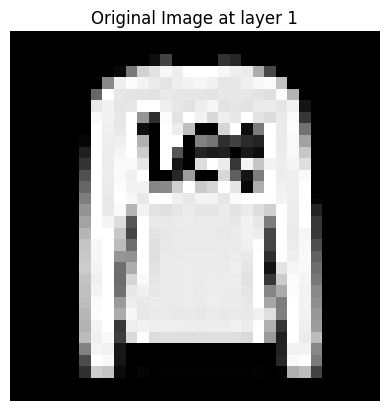

In [9]:
original_image = np.loadtxt(f"Images/Id{image_id}_Type0_L1_C0.csv", delimiter=",", dtype=str)
original_image = np.delete(original_image, 32, axis=1)
original_image = original_image.astype(int)

original_image.shape



fig, ax = plt.subplots()

ax.imshow(original_image, cmap='gray', vmin=0, vmax=255)
ax.axis('off')

ax.set_title("Original Image at layer 1")

plt.show()

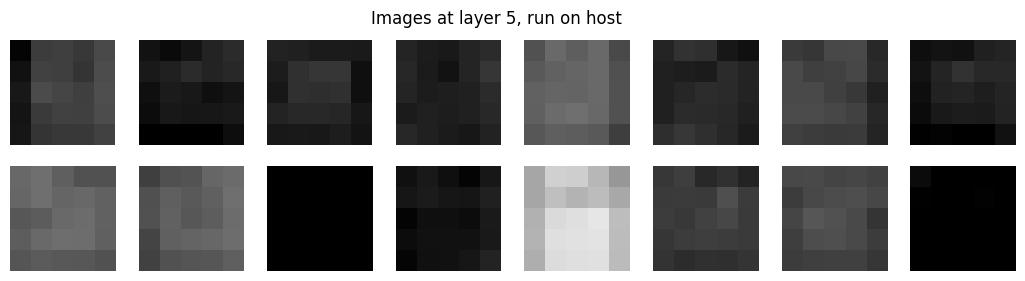

In [10]:
layer_5_images = []

for i in range(16):
    temp = np.loadtxt(f"Images/Id{image_id}_Type0_L5_C{i}.csv", delimiter=",", dtype=str)
    temp = np.delete(temp, 5, axis=1)
    temp = temp.astype(float)
    layer_5_images.append(temp)

layer_5_images[0].shape



fig, ax = plt.subplots(2, 8, figsize=(13, 3))

for i in range(16):
    curr_ax = ax[i // 8, i % 8]
    curr_ax.imshow(layer_5_images[i], cmap='gray', vmin=0, vmax=255)
    curr_ax.axis('off')

fig.suptitle("Images at layer 5, run on host")

plt.show()

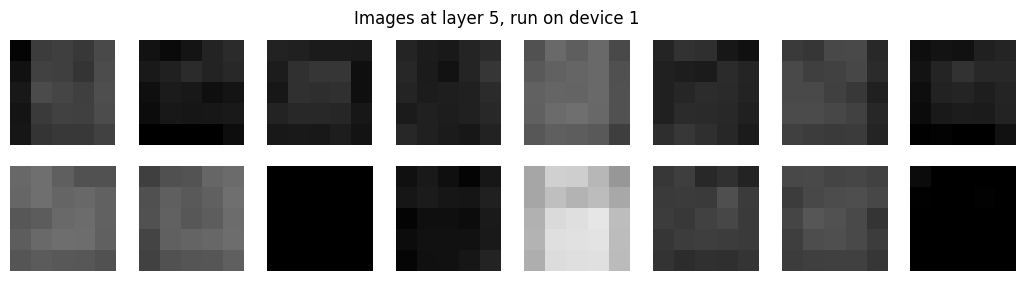

In [11]:
layer_5_images = []

for i in range(16):
    temp = np.loadtxt(f"Images/Id{image_id}_Type1_L5_C{i}.csv", delimiter=",", dtype=str)
    temp = np.delete(temp, 5, axis=1)
    temp = temp.astype(float)
    layer_5_images.append(temp)

layer_5_images[0].shape



fig, ax = plt.subplots(2, 8, figsize=(13, 3))

for i in range(16):
    curr_ax = ax[i // 8, i % 8]
    curr_ax.imshow(layer_5_images[i], cmap='gray', vmin=0, vmax=255)
    curr_ax.axis('off')

fig.suptitle("Images at layer 5, run on device 1")

plt.show()

Chạy tất cả kernel

In [12]:
# Run all kernels to check the accuracy
!./Faker oneImage 1 -1

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835660288 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Attempting to read file
Trying to read image with size (28, 28)
Trying to read image with size (28, 28)
Done about 0%, i = 1
Done about 20%, i = 12000
Done about 40%, i = 24000
Done about 60%, i = 36000
Done about 80%, i = 48000
Finish pre-processing data

Done about 0%, i = 1
Done about 20%, i = 2000
Done about 40%, i = 4000
Done about 60%, i = 6000
Done about 80%, i = 8000
Finish pre-processing data

1024Load the kernels by default
Print the image by default
The default block size for layer 1 and layer 2 is 16
The default block size for layer 3 and layer 4 is 8

Attempting to assign host memory

Image size at layer 1: (32, 32, 1)
Image size at layer 2: (28, 28, 6)
Image size at layer 3: (14, 14, 6)
Image size at layer 4: (10, 10, 1

Chạy tất cả ảnh

In [13]:
# Run all images on host
!./Faker oneImage -1 0 L

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835660288 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Attempting to read file
Trying to read image with size (28, 28)
Trying to read image with size (28, 28)
Done about 0%, i = 1
Done about 20%, i = 12000
Done about 40%, i = 24000
Done about 60%, i = 36000
Done about 80%, i = 48000
Finish pre-processing data

Done about 0%, i = 1
Done about 20%, i = 2000
Done about 40%, i = 4000
Done about 60%, i = 6000
Done about 80%, i = 8000
Finish pre-processing data

1024Load the kernels by default
Print the image by default
The default block size for layer 1 and layer 2 is 16
The default block size for layer 3 and layer 4 is 8

Attempting to assign host memory

Image size at layer 1: (32, 32, 1)
Image size at layer 2: (28, 28, 6)
Image size at layer 3: (14, 14, 6)
Image size at layer 4: (10, 10, 1

In [14]:
# Run all images on device 1
!./Faker oneImage -1 1 L

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835660288 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Attempting to read file
Trying to read image with size (28, 28)
Trying to read image with size (28, 28)
Done about 0%, i = 1
Done about 20%, i = 12000
Done about 40%, i = 24000
Done about 60%, i = 36000
Done about 80%, i = 48000
Finish pre-processing data

Done about 0%, i = 1
Done about 20%, i = 2000
Done about 40%, i = 4000
Done about 60%, i = 6000
Done about 80%, i = 8000
Finish pre-processing data

1024Load the kernels by default
Print the image by default
The default block size for layer 1 and layer 2 is 16
The default block size for layer 3 and layer 4 is 8

Attempting to assign host memory

Image size at layer 1: (32, 32, 1)
Image size at layer 2: (28, 28, 6)
Image size at layer 3: (14, 14, 6)
Image size at layer 4: (10, 10, 1

In [15]:
# Run all images on device 2
!./Faker oneImage -1 2 L

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835660288 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Attempting to read file
Trying to read image with size (28, 28)
Trying to read image with size (28, 28)
Done about 0%, i = 1
Done about 20%, i = 12000
Done about 40%, i = 24000
Done about 60%, i = 36000
Done about 80%, i = 48000
Finish pre-processing data

Done about 0%, i = 1
Done about 20%, i = 2000
Done about 40%, i = 4000
Done about 60%, i = 6000
Done about 80%, i = 8000
Finish pre-processing data

1024Load the kernels by default
Print the image by default
The default block size for layer 1 and layer 2 is 16
The default block size for layer 3 and layer 4 is 8

Attempting to assign host memory

Image size at layer 1: (32, 32, 1)
Image size at layer 2: (28, 28, 6)
Image size at layer 3: (14, 14, 6)
Image size at layer 4: (10, 10, 1

In [16]:
# Run all images on device 3
!./Faker oneImage -1 3 L

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835660288 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Attempting to read file
Trying to read image with size (28, 28)
Trying to read image with size (28, 28)
Done about 0%, i = 1
Done about 20%, i = 12000
Done about 40%, i = 24000
Done about 60%, i = 36000
Done about 80%, i = 48000
Finish pre-processing data

Done about 0%, i = 1
Done about 20%, i = 2000
Done about 40%, i = 4000
Done about 60%, i = 6000
Done about 80%, i = 8000
Finish pre-processing data

1024Load the kernels by default
Print the image by default
The default block size for layer 1 and layer 2 is 16
The default block size for layer 3 and layer 4 is 8

Attempting to assign host memory

Image size at layer 1: (32, 32, 1)
Image size at layer 2: (28, 28, 6)
Image size at layer 3: (14, 14, 6)
Image size at layer 4: (10, 10, 1

In [17]:
# Run all images with stream on kernel 2
!./Faker withStream

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835660288 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Attempting to read file
Trying to read image with size (28, 28)
Trying to read image with size (28, 28)
Done about 0%, i = 1
Done about 20%, i = 12000
Done about 40%, i = 24000
Done about 60%, i = 36000
Done about 80%, i = 48000
Finish pre-processing data

Done about 0%, i = 1
Done about 20%, i = 2000
Done about 40%, i = 4000
Done about 60%, i = 6000
Done about 80%, i = 8000
Finish pre-processing data

1024The default block size for layer 1 and layer 2 is 16
The default block size for layer 3 and layer 4 is 8

Attempting to load the kernel

Attempting to assign host memory

Image size at layer 1: (32, 32, 1)
Image size at layer 2: (28, 28, 6)
Image size at layer 3: (14, 14, 6)
Image size at layer 4: (10, 10, 16)
Image size at layer 5

In [18]:
# Run all images by putting them into a bigger one on kernel 2
!./Faker biggerImage

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835660288 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Attempting to read file
Trying to read image with size (28, 28)
Trying to read image with size (28, 28)
Done about 0%, i = 1
Done about 20%, i = 12000
Done about 40%, i = 24000
Done about 60%, i = 36000
Done about 80%, i = 48000
Finish pre-processing data

Done about 0%, i = 1
Done about 20%, i = 2000
Done about 40%, i = 4000
Done about 60%, i = 6000
Done about 80%, i = 8000
Finish pre-processing data

1024The default block size for layer 1 and layer 2 is 16
The default block size for layer 3 and layer 4 is 8

Attempting to load the kernel

Attempting to assign host memory

Image size at layer 1: (32, 32, 1)
Image size at layer 2: (28, 28, 6)
Image size at layer 3: (14, 14, 6)
Image size at layer 4: (10, 10, 16)
Image size at layer 5

<h1>IV. Những cài đặt và bổ sung - những cải tiến trong code:</h1>

- Có bổ sung 1 giải pháp: khi ta ghép 100 ảnh ngang - dọc thì thời gian xử lí sẽ nhanh hơn rất nhiều.
- Các hàm còn lại đều cố gắng nhưng kết quả lại trở về như cũ.
- Đã fix xong lỗi chạy không được trong colab (trong khi vấn đáp bị một vài bug nhỏ trong main.cu và đã sửa để hiển thị thời gian chạy).